<a href="https://colab.research.google.com/github/lucianocolla123/World-Bank-Data-Analysis-in-Python/blob/main/ISM4211_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
# Import python pakages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

File Load

In [ ]:
file_path = '/content/IEG_World_Bank_Project_Performance_Ratings_20240624.csv'

# Update the path if necessary
df = pd.read_csv(file_path)

Question 1: Which regions and countries have the highest and lowest project success rates?

Region
Africa                          3.391304
East Asia And Pacific           4.201292
Eastern And Southern Africa     3.877347
Europe And Central Asia         4.140062
Latin America And Caribbean     3.952558
Middle East And North Africa    3.837963
Other                           3.714286
South Asia                      4.001538
Western And Central Africa      3.777130
dtype: float64


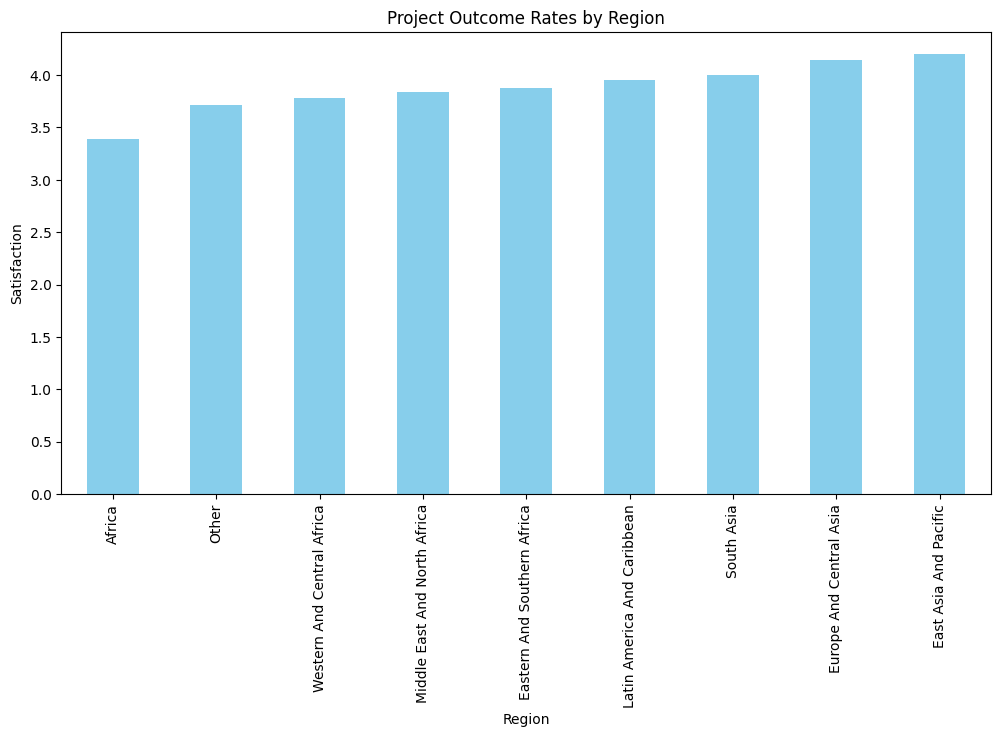

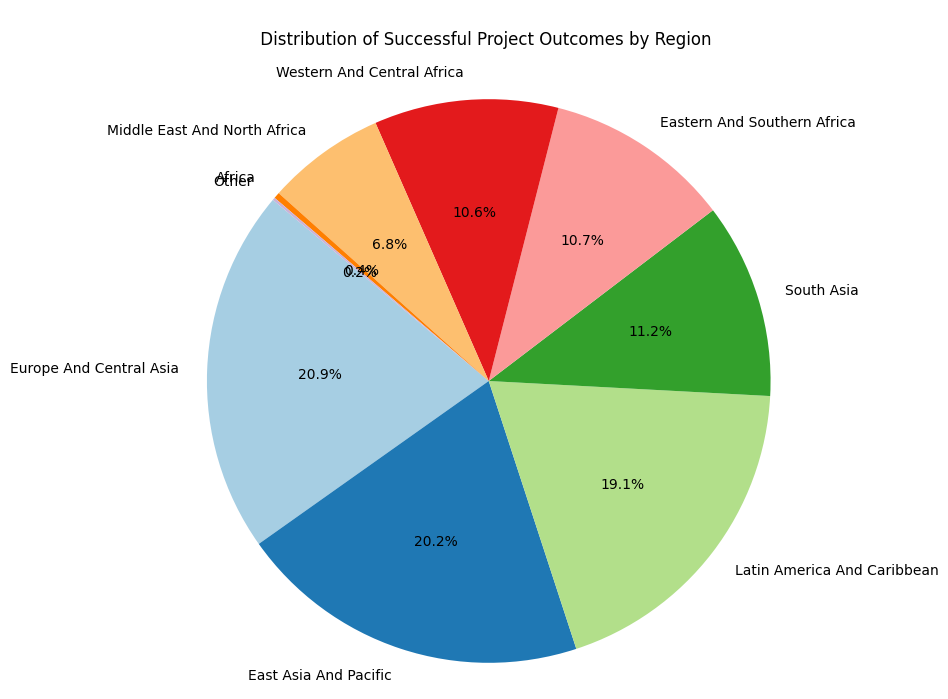

In [ ]:
# Rename 'WB Region' column to 'Region'
df.rename(columns = {'WB Region' : 'Region'}, inplace = True)

# Create dictionary with 'Region' and 'Country' as key and value
region_country_dict = df[['Region', 'Country']].groupby('Region')['Country'].apply(list).to_dict()

# Convert 'Outcome' column results into numeric scale
outcome_scale = {'Highly Satisfactory': 6, 'Satisfactory': 5, 'Moderately Satisfactory': 4, 'Moderately Unsatisfactory': 3, 'Unsatisfactory': 2, 'Highly Unsatisfactory': 1}
df['Numeric_Outcome'] = df['Outcome'].replace(outcome_scale)
df['Numeric_Outcome'].fillna(0, inplace = True)

# Create a function to calculate satisfaction by region
def calculate_satisfaction(group):
   satisfaction = group['Numeric_Outcome'].mean()
   return satisfaction
region_satisfaction = df.groupby('Region').apply(calculate_satisfaction)
print(region_satisfaction)

# Plot outcome rates by region
plt.figure(figsize=(12, 6))
region_satisfaction.sort_values().plot(kind='bar', color='skyblue')
plt.title('Project Outcome Rates by Region')
plt.xlabel('Region')
plt.ylabel('Satisfaction')
plt.show()

# ----------------------------------- Pie Chart ------------------------------------

# Pie chart for successful outcomes by region
# Count the distribution of successful outcomes by region
successful_outcomes = df[df['Numeric_Outcome'] >= 5]
region_success_counts = successful_outcomes['Region'].value_counts()
# Plot
plt.figure(figsize=(8, 8))
plt.pie(region_success_counts, labels=region_success_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(region_success_counts))))
plt.title('\n Distribution of Successful Project Outcomes by Region  \n')
plt.axis('equal')
plt.show()

Question 2: How does the 'Global Practice' impact the likelihood of project success across different regions?

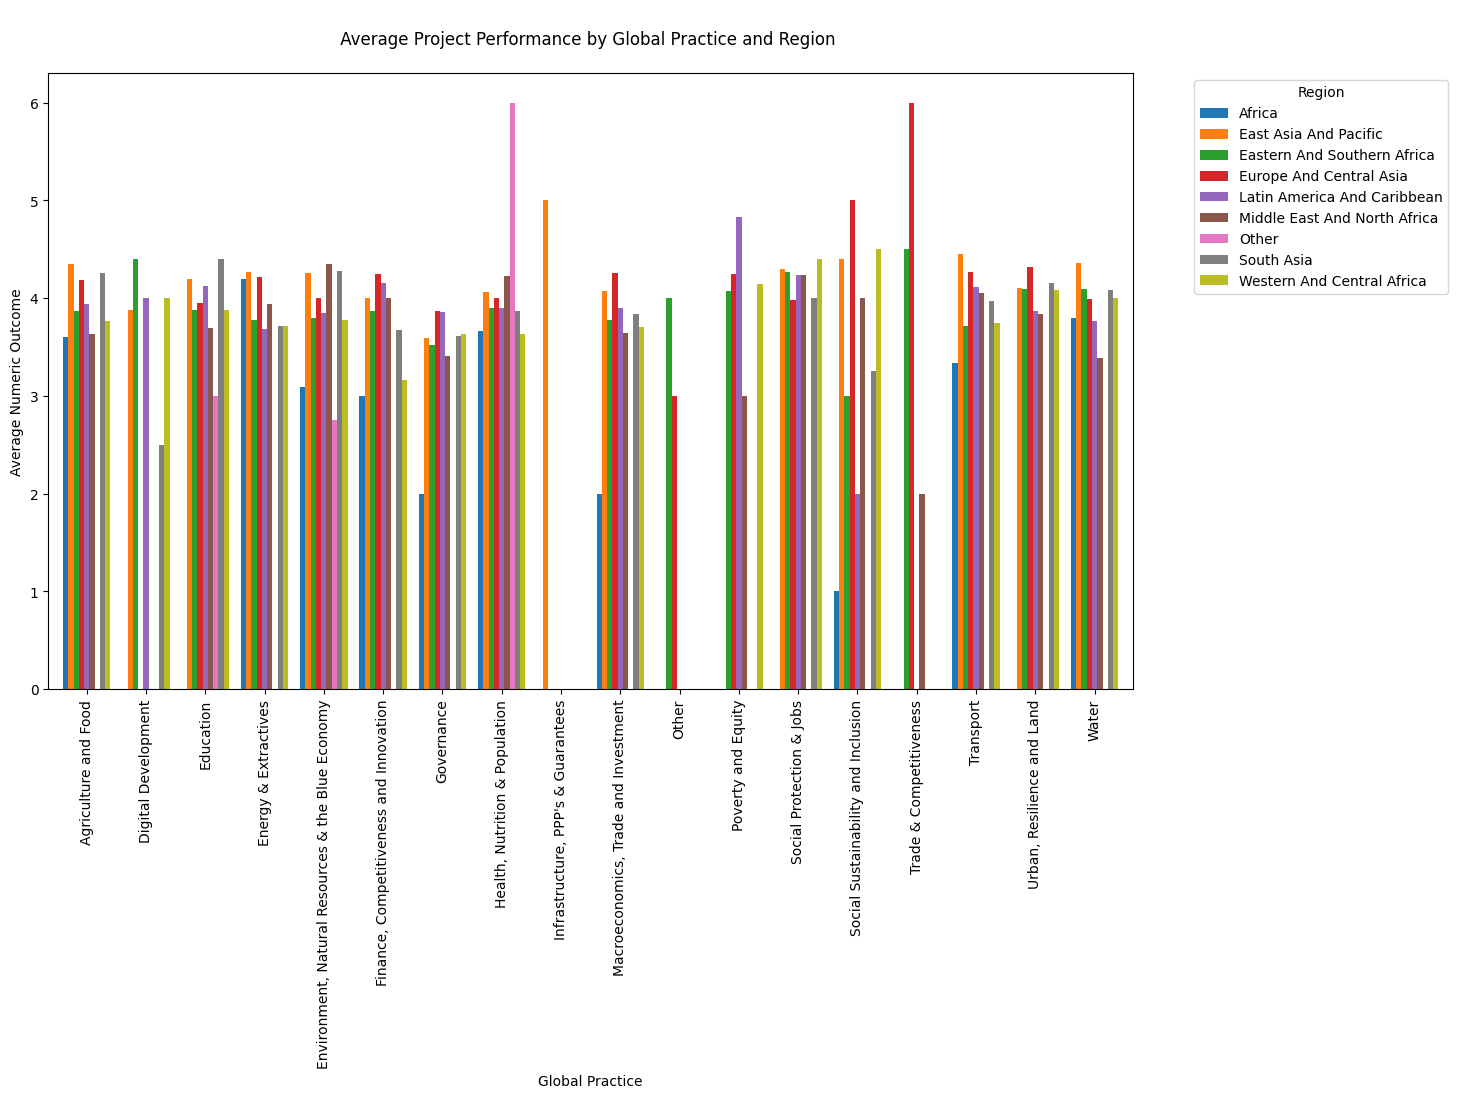

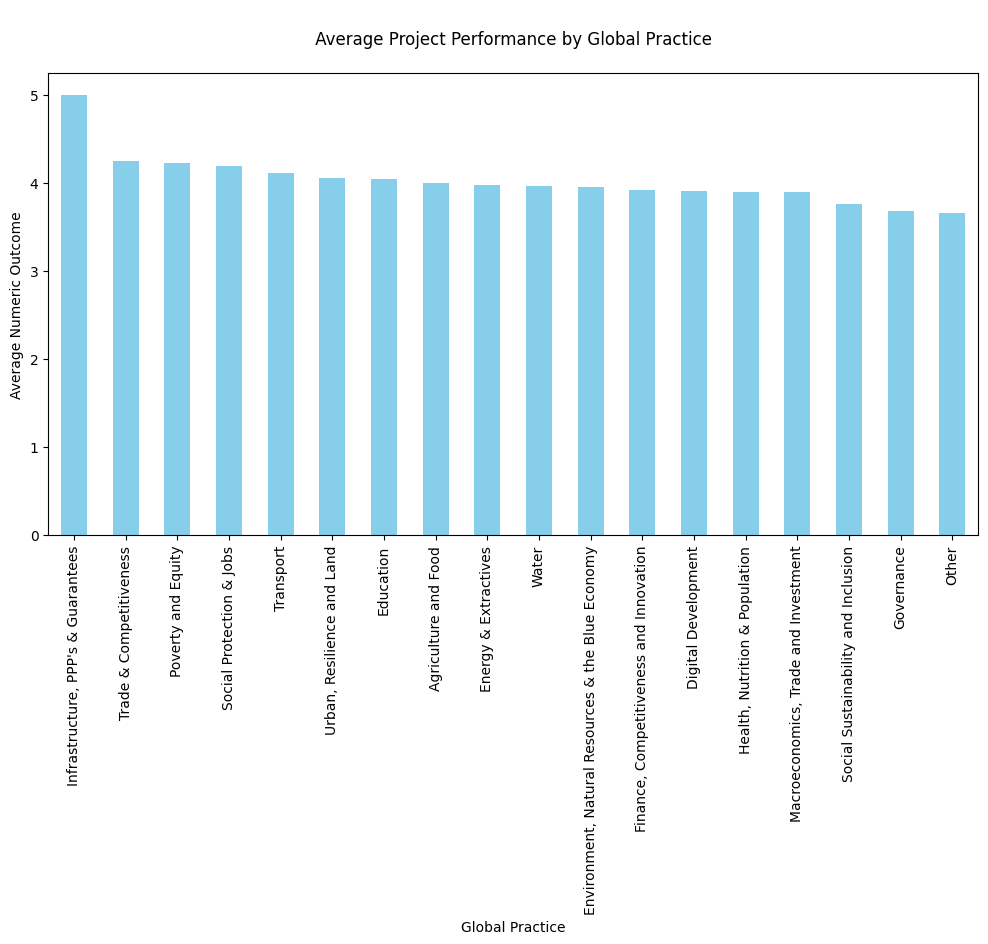

<ipython-input-7-93a2a0b8d969>:34: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


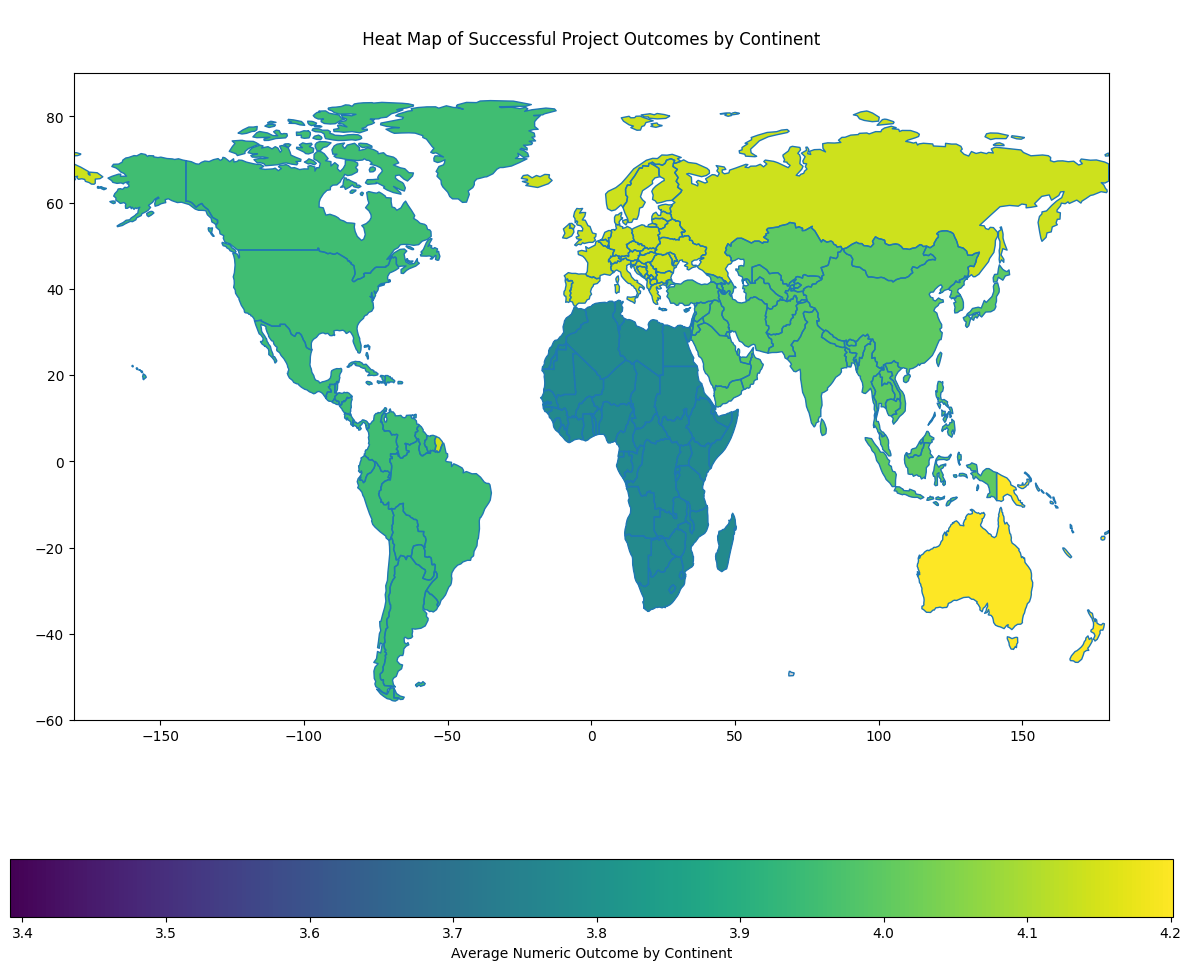

In [ ]:
# Group by Global Practice and Region, then calculate mean numeric outcome
grouped_data = df.groupby(['Global Practice', 'Region'])['Numeric_Outcome'].mean().reset_index()

# Pivot the grouped data for easier plotting
pivot_data = grouped_data.pivot(index='Global Practice', columns='Region', values= 'Numeric_Outcome')

# ----------------------------------- Bar Plot ------------------------------------

# Bar Plot of All variables
pivot_data.plot(kind='bar', figsize=(14, 8), width=0.8)
plt.title('\n Average Project Performance by Global Practice and Region  \n')
plt.xlabel('Global Practice')
plt.ylabel('Average Numeric Outcome')
plt.xticks(rotation=90)
plt.legend(title='Region', bbox_to_anchor = (1.05,1), loc='upper left')
plt.show()
# ----------------------------------- Bar Plot ------------------------------------

# Bar plot of success by Global Practice
# Group by Global Practice and calculate the average numeric outcome
practice_success = df.groupby('Global Practice')['Numeric_Outcome'].mean().sort_values(ascending=False)
# Plot
plt.figure(figsize=(12, 6))
practice_success.plot(kind='bar', color='skyblue')
plt.title('\n Average Project Performance by Global Practice \n')
plt.xlabel('Global Practice')
plt.ylabel('Average Numeric Outcome')
plt.xticks(rotation=90)
plt.show()

# ----------------------------------- Heatmap ---------------------------------------

# Load the world map shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Define region mapping based on continents/sub-regions
region_mapping = {
    'Africa': ['Africa'],
    'East Asia And Pacific': ['Asia', 'Oceania'],
    'Eastern And Southern Africa': ['Africa'],
    'Europe And Central Asia': ['Europe', 'Asia'],
    'Latin America And Caribbean': ['South America', 'North America'],
    'Middle East And North Africa': ['Africa', 'Asia'],
    'South Asia': ['Asia'],
    'Western And Central Africa': ['Africa']
}
# Group by Region and calculate the average numeric outcome
region_success = df.groupby('Region')['Numeric_Outcome'].mean().reset_index()

# Expand the region_success dataframe to map multiple continents to each region
expanded_data = []
for region, continents in region_mapping.items():
    if region in region_success['Region'].values:
        average_outcome = region_success.loc[region_success['Region'] == region, 'Numeric_Outcome'].values[0]
        for continent in continents:
            expanded_data.append([continent, average_outcome])

# Create a new dataframe with the expanded data
expanded_region_success = pd.DataFrame(expanded_data, columns=['Continent', 'Numeric_Outcome'])

# Merge the regional data with the world map based on continent
world['Continent'] = world['continent'].replace({
  'Seven seas (open ocean)': 'Other'
})

# Merge the regional data with the world map
merged = world.set_index('Continent').join(expanded_region_success.set_index('Continent'), how='left')

# Plotting: Heat map
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
world.boundary.plot(ax=ax, linewidth=1)
merged.plot(column='Numeric_Outcome', ax=ax, legend=True,
            legend_kwds={'label': "Average Numeric Outcome by Continent",
                         'orientation': "horizontal"},
            missing_kwds={"color": "lightgrey", "label": "No Data"})
plt.title('\n Heat Map of Successful Project Outcomes by Continent \n')

# Adjust axis limits to make the map rectangular
ax.set_xlim(-180, 180)
ax.set_ylim(-60, 90)
ax.set_aspect(1.5)

plt.show()

Question 3: Does the 'M&E Quality' (Monitoring and Evaluation Quality) correlate with the overall 'Bank Performance'?

Correlation coefficient: 0.57



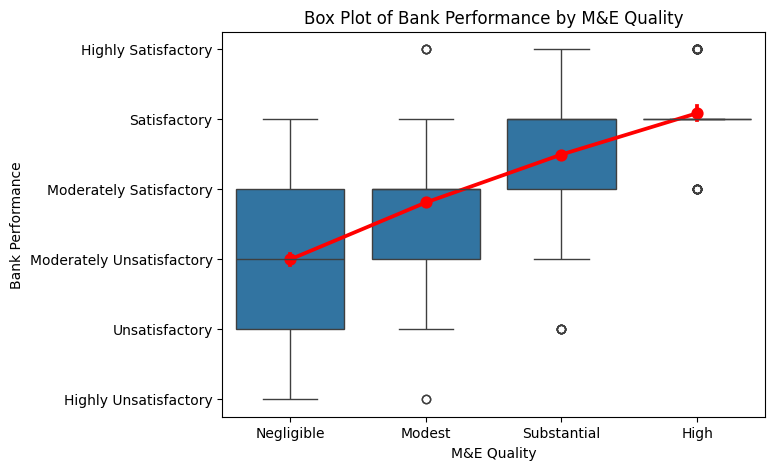

In [ ]:
# Convert Bank Performance to numerical rankings
bp_scale = {'Highly Satisfactory': 6, 'Satisfactory': 5, 'Moderately Satisfactory': 4, 'Moderately Unsatisfactory': 3, 'Unsatisfactory': 2, 'Highly Unsatisfactory': 1}
df['Numeric Bank Performance'] = df['Bank Performance'].replace(bp_scale)

# Convert M&E Quality to numerical rankings
me_scale = {'High': 4, 'Substantial': 3, 'Modest': 2, 'Negligible': 1}
df['Numeric M&E Quality'] = df['M&E Quality'].replace(me_scale)

df.dropna(subset=['Numeric Bank Performance', 'Numeric M&E Quality'], inplace=True)

# Calculate correlation coefficient
correlation = df[['Numeric M&E Quality', 'Numeric Bank Performance']].corr().iloc[0, 1]

# Present the correlation coefficient
print(f"Correlation coefficient: {correlation:.2f}")
print()

#Order the categories for the graph
df['M&E Quality'] = pd.Categorical(df['M&E Quality'], categories=['Negligible', 'Modest', 'Substantial', 'High'], ordered=True)

# Box plot
plt.figure(figsize=(7, 5))
sns.boxplot(x='M&E Quality', y='Numeric Bank Performance', data=df)

sns.pointplot(x='M&E Quality', y='Numeric Bank Performance', data=df, estimator=np.mean, color='red')

# Add labels and title
plt.xlabel('M&E Quality')
plt.ylabel('Bank Performance')
plt.title('Box Plot of Bank Performance by M&E Quality')

# Set custom tick labels for y-axis
plt.yticks([1, 2, 3, 4, 5, 6], ['Highly Unsatisfactory', 'Unsatisfactory', 'Moderately Unsatisfactory', 'Moderately Satisfactory', 'Satisfactory', 'Highly Satisfactory'])

# Show the plot
plt.show()


Question 4: What patterns emerge from the 'Final Closing FY' in relation to project success and sustainability?

Question 5: Are there specific 'Country Lending Groups' that show consistent trends in project performance?


Unique values in 'Country Lending Group':
['Satisfactory' 'Moderately Satisfactory' 'Unsatisfactory'
 'Moderately Unsatisfactory' 'Highly Unsatisfactory' 'Highly Satisfactory'
 nan]

Unique values in 'Country Lending Group':
['IDA' 'Other' 'IBRD' 'Blend']
First few rows of the dataset:
               As of Date Project ID  \
0  04/04/2024 12:00:00 AM    P078618   
1  04/04/2024 12:00:00 AM    P077533   
2  04/04/2024 12:00:00 AM    P077896   
3  04/04/2024 12:00:00 AM    P077417   
4  04/04/2024 12:00:00 AM    P077779   

                                        Project Name   WB Region      Country  \
0      Programmatic Support for Institution Building  South Asia  Afghanistan   
1  Emergency Community Empowerment and Public Wor...  South Asia  Afghanistan   
2  Emergency Education Rehabilitation & Developme...  South Asia  Afghanistan   
3            Emergency Public Administration Project  South Asia  Afghanistan   
4    Emergency Infrastructure Reconstruction Project  South Asia  

<ipython-input-4-438233510b35>:78: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='Country Lending Group', y='mean', data=grouped_df, ci='sd')


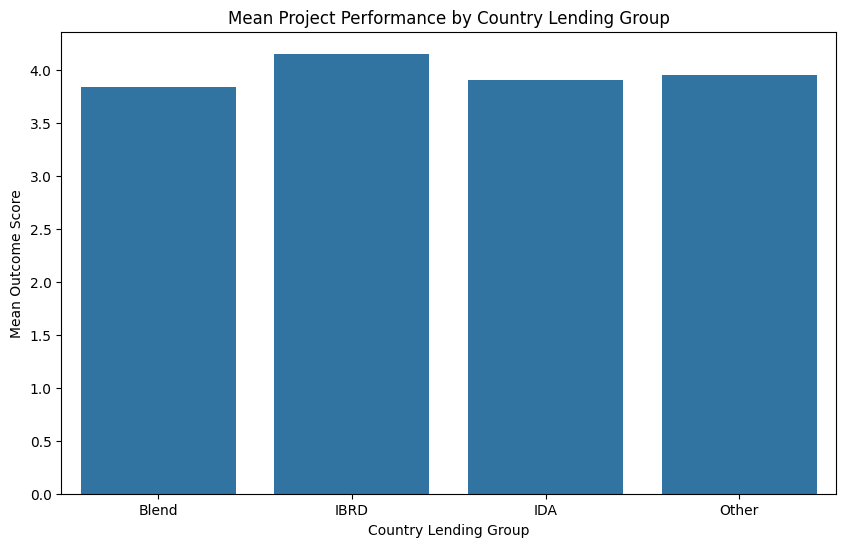

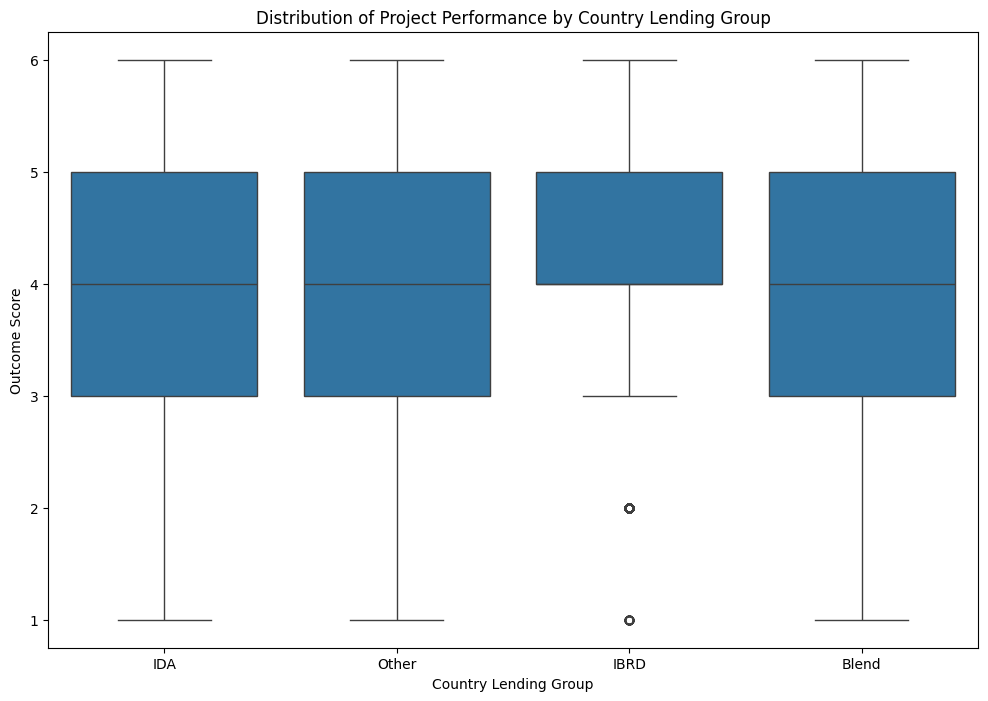

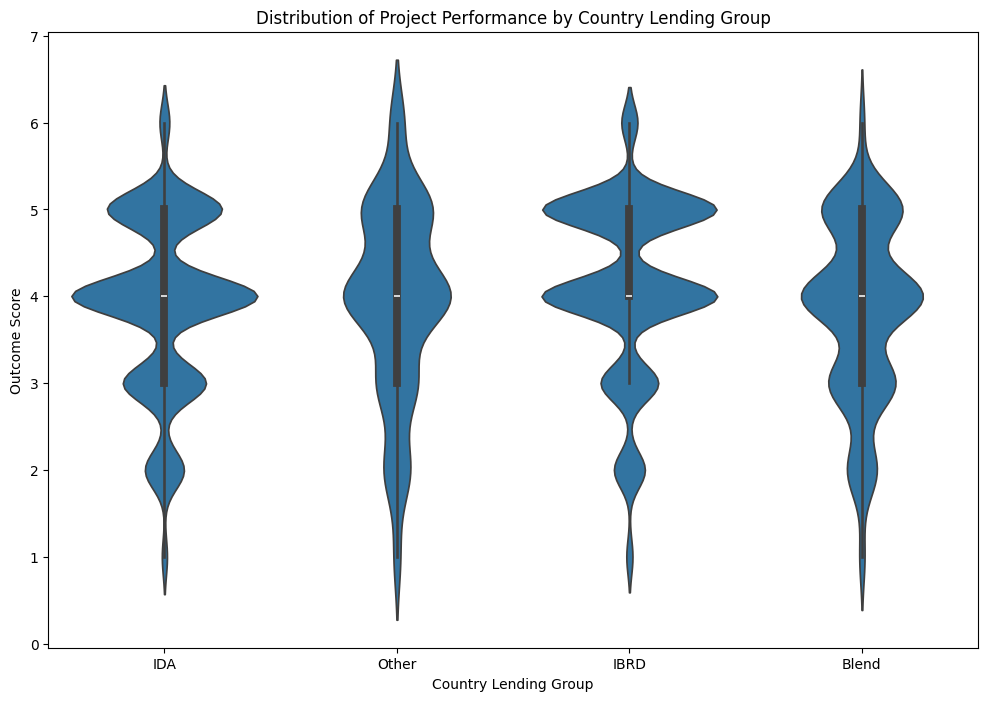


ANOVA test result:
F-statistic: 30.22953262032336, p-value: 2.209635104176128e-19
  Country Lending Group      mean       std
0                 Blend  3.831731  1.022896
1                  IBRD  4.148899  1.004634
2                   IDA  3.904384  0.997290
3                 Other  3.946809  1.119548
F_onewayResult(statistic=30.22953262032336, pvalue=2.209635104176128e-19)


In [ ]:
# Find unique values in a specific column (e.g., 'Country Lending Group')
from scipy.stats import f_oneway

unique_values = df['Outcome'].unique()


# Display the unique values
print("\nUnique values in 'Country Lending Group':")
print(unique_values)


unique_groups = df['Country Lending Group'].unique()


# Display the unique values
print("\nUnique values in 'Country Lending Group':")
print(unique_groups)
def analyze_trends(file_path):
    # Load the dataset
    df = pd.read_csv(file_path)


    # Display the first few rows of the dataset
    print("First few rows of the dataset:")
    print(df.head())


    # Display the data types of the columns
    print("\nData types of the columns:")
    print(df.dtypes)


    # Check for missing values
    print("\nMissing values in each column:")
    print(df.isnull().sum())


    # Drop rows with missing values in the relevant columns
    df = df.dropna(subset=['Country Lending Group', 'Outcome'])


    # Define the mapping for ordinal encoding of the outcome metrics
    outcome_mapping = {
        'Highly Unsatisfactory': 1,
        'Unsatisfactory': 2,
        'Moderately Unsatisfactory': 3,
        'Moderately Satisfactory': 4,
        'Satisfactory': 5,
        'Highly Satisfactory': 6
    }


    # Apply the mapping to the 'Outcome' column
    df['Outcome'] = df['Outcome'].map(outcome_mapping)


    # Check for unmapped values
    if df['Outcome'].isnull().any():
        print("\nUnmapped values found in 'Outcome' column:")
        print(df[df['Outcome'].isnull()])


    # Ensure there are no unmapped values
    df = df.dropna(subset=['Outcome'])


    # Group by 'Country Lending Group' and calculate mean and std of 'Outcome'
    grouped_df = df.groupby('Country Lending Group')['Outcome'].agg(['mean', 'std']).reset_index()


    # Display the grouped DataFrame
    print("\nGrouped DataFrame with mean and std of 'Outcome':")
    print(grouped_df)


    # Visualize mean 'Outcome' by 'Country Lending Group'
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Country Lending Group', y='mean', data=grouped_df, ci='sd')
    plt.title('Mean Project Performance by Country Lending Group')
    plt.ylabel('Mean Outcome Score')
    plt.xlabel('Country Lending Group')
    plt.show()  # Ensure the plot is displayed

    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Country Lending Group', y='Outcome', data=df)
    plt.title('Distribution of Project Performance by Country Lending Group')
    plt.ylabel('Outcome Score')
    plt.xlabel('Country Lending Group')
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.violinplot(x='Country Lending Group', y='Outcome', data=df)
    plt.title('Distribution of Project Performance by Country Lending Group')
    plt.ylabel('Outcome Score')
    plt.xlabel('Country Lending Group')
    plt.show()


    # Additional analysis - ANOVA test
    groups = [df[df['Country Lending Group'] == group]['Outcome'] for group in df['Country Lending Group'].unique()]
    anova_result = f_oneway(*groups)

    print("\nANOVA test result:")
    print(f"F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}")

    return grouped_df, anova_result

# Example usage

grouped_df, anova_result = analyze_trends(file_path)
print(grouped_df)
print(anova_result)

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

# Identify unique values in the 'Country Lending Group' column
clg_values = df['Country Lending Group'].unique()
print("\nUnique values in 'Country Lending Group':")
print(clg_values)

# Group by 'Country Lending Group' and list unique 'Country' values within each group
grouped_values = df.groupby('Country Lending Group')['Country'].unique().reset_index()

# Display the grouped values without truncation
print("\nUnique 'Country' values within each 'Country Lending Group':")
for index, row in grouped_values.iterrows():
    print(f"Country Lending Group: {row['Country Lending Group']}")
    print(f"Countries: {', '.join(row['Country'])}\n")


Unique values in 'Country Lending Group':
['IDA' 'Other' 'IBRD' 'Blend']

Unique 'Country' values within each 'Country Lending Group':
Country Lending Group: Blend
Countries: Cabo Verde, Cameroon, Congo, Republic of, Dominica, Fiji, Grenada, Kenya, Nigeria, Pakistan, Papua New Guinea, St. Lucia, St. Vincent and the Grenadines, Timor-Leste, Uzbekistan, Zimbabwe

Country Lending Group: IBRD
Countries: Albania, Algeria, Angola, Antigua and Barbuda, Argentina, Armenia, Azerbaijan, Belarus, Belize, Bolivia, Bosnia and Herzegovina, Botswana, Brazil, Bulgaria, Chile, China, Colombia, Costa Rica, Croatia, Dominican Republic, Ecuador, Egypt, Arab Republic of, El Salvador, Eswatini, Gabon, Georgia, Guatemala, India, Indonesia, Iran, Islamic Republic of, Iraq, Jamaica, Jordan, Kazakhstan, Lebanon, Malaysia, Mauritius, Mexico, Moldova, Mongolia, Montenegro, Morocco, Namibia, North Macedonia, Panama, Paraguay, Peru, Philippines, Poland, Romania, Russian Federation, Serbia, Seychelles, South Africa